<a href="https://colab.research.google.com/github/Zakuta/D-QRL/blob/main/Hurrah!_QRL_TFQ_DQN_try2_01_03_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install equinox
!pip install tensorcircuit
!pip install -U qiskit
!pip install tensorcircuit
!pip install cirq
!pip install openfermion
!pip install gymnax
!pip install brax
!pip install distrax
!pip install flax
!pip install flashbax
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import jax
from jax import config

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

import jax.numpy as jnp
DTYPE=jnp.float32

import chex
import numpy as np


import optax
from optax import ScaleByAdamState, ScaleByAmsgradState, update_moment, update_moment_per_elem_norm
from optax import scale_by_learning_rate
from optax._src import base, utils, combine, numerics


from flax import struct
from functools import partial
import tensorcircuit as tc

# import tensorflow as tf
# from sklearn.decomposition import PCA
import equinox as eqx
import types
from jaxtyping import Array, PRNGKeyArray, PyTree
from typing import Union, Sequence, List, NamedTuple, Optional, Tuple, Any, Literal, TypeVar
import jax.tree_util as jtu
import gymnax
import distrax
from gymnax.environments import environment, spaces
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper
import flashbax as fbx
import wandb
from gymnax.wrappers.purerl import FlattenObservationWrapper, LogWrapper
from collections import deque


K = tc.set_backend("jax")

Tensor = Any

In [2]:
# TF and (optax, PT) implementations of Adam (Kingma Ba, 2014) are a bit different. Hence, in the spirit of keeping everything the same as QRL tutorial, I re-implemented
# Adam and AMSGrad in TF style. For further details go here: https://github.com/google-deepmind/optax/issues/571

def scale_by_adam_tf_style(
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    mu_dtype = None,
) -> base.GradientTransformation:
  """Rescale updates according to the Adam algorithm.
  WARNING: This is a TensorFlow-style Adam optimizer that uses the
    formulation just before Section 2.1 of the Kingma and Ba paper
    rather than the formulation in Algorithm 1, the "epsilon" referred
    to here is "epsilon hat" in the paper.
  Args:
    b1: Decay rate for the exponentially weighted average of grads.
    b2: Decay rate for the exponentially weighted average of squared grads.
    eps: Term added to the denominator to improve numerical stability. (epsilon hat)
    eps_root: Term added to the denominator inside the square-root to improve
      numerical stability when backpropagating gradients through the rescaling.
    mu_dtype: Optional `dtype` to be used for the first order accumulator; if
      `None` then the `dtype` is inferred from `params` and `updates`.
  Returns:
    A `GradientTransformation` object.
  """

  mu_dtype = utils.canonicalize_dtype(mu_dtype)

  def init_fn(params):
    mu = jax.tree_util.tree_map(  # First moment
        lambda t: jnp.zeros_like(t, dtype=mu_dtype), params)
    nu = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second moment
    return ScaleByAdamState(count=jnp.zeros([], jnp.int32), mu=mu, nu=nu)

  def update_fn(updates, state, params=None):
    del params
    mu = update_moment(updates, state.mu, b1, 1)
    nu = update_moment_per_elem_norm(updates, state.nu, b2, 2)
    count_inc = numerics.safe_int32_increment(state.count)

    ### `optax` default adam implementation
    # mu_hat = bias_correction(mu, b1, count_inc)
    # nu_hat = bias_correction(nu, b2, count_inc)
    # updates = jax.tree_util.tree_map(
    #     lambda m, v: m / (jnp.sqrt(v + eps_root) + eps), mu_hat, nu_hat)
    ### Tensorflow adam implementation
    alpha = jnp.sqrt(1- b2**count_inc) / (1-b1**count_inc)
    updates = jax.tree_util.tree_map(
        lambda m, v: (m *  alpha) / (jnp.sqrt(v + eps_root) + eps), mu, nu) #
    mu = utils.cast_tree(mu, mu_dtype)
    return updates, ScaleByAdamState(count=count_inc, mu=mu, nu=nu)

  return base.GradientTransformation(init_fn, update_fn)


def adam_tf_style(
    learning_rate,
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-7,
    eps_root: float = 0.0,
    mu_dtype = None,
):
  return combine.chain(
      scale_by_adam_tf_style(
          b1=b1, b2=b2, eps=eps, eps_root=eps_root, mu_dtype=mu_dtype),
      scale_by_learning_rate(learning_rate),
  )


def scale_by_amsgrad_tf_style(
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    mu_dtype = None,
) -> base.GradientTransformation:
  """Rescale updates according to the AmsGrad algorithm.
  WARNING: This is a TensorFlow-style Adam optimizer that uses the
    formulation just before Section 2.1 of the Kingma and Ba paper
    rather than the formulation in Algorithm 1, the "epsilon" referred
    to here is "epsilon hat" in the paper.
  Args:
    b1: Decay rate for the exponentially weighted average of grads.
    b2: Decay rate for the exponentially weighted average of squared grads.
    eps: Term added to the denominator to improve numerical stability. (epsilon hat)
    eps_root: Term added to the denominator inside the square-root to improve
      numerical stability when backpropagating gradients through the rescaling.
    mu_dtype: Optional `dtype` to be used for the first order accumulator; if
      `None` then the `dtype` is inferred from `params` and `updates`.
  Returns:
    A `GradientTransformation` object.
  """

  mu_dtype = utils.canonicalize_dtype(mu_dtype)

  def init_fn(params):
    mu = jax.tree_util.tree_map(  # First moment
        lambda t: jnp.zeros_like(t, dtype=mu_dtype), params)
    nu = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second moment
    nu_max = jax.tree_util.tree_map(jnp.zeros_like, params)
    return ScaleByAmsgradState(count=jnp.zeros([], jnp.int32), mu=mu, nu=nu,
                               nu_max=nu_max)

  def update_fn(updates, state, params=None):
    del params
    mu = update_moment(updates, state.mu, b1, 1)
    nu = update_moment_per_elem_norm(updates, state.nu, b2, 2)
    count_inc = numerics.safe_int32_increment(state.count)

    ### `optax` default adam implementation
    # mu_hat = bias_correction(mu, b1, count_inc)
    # nu_hat = bias_correction(nu, b2, count_inc)
    # nu_max = jax.tree_util.tree_map(jnp.maximum, state.nu_max, nu_hat)
    # updates = jax.tree_util.tree_map(
    #     lambda m, v: m / (jnp.sqrt(v + eps_root) + eps), mu_hat, nu_max)
    ### Tensorflow amsgrad implementation
    nu_max = jax.tree_util.tree_map(jnp.maximum, state.nu_max, nu)
    alpha = jnp.sqrt(1 - b2**count_inc) / (1 - b1**count_inc)
    updates = jax.tree_util.tree_map(
        lambda m, v: (m *  alpha) / (jnp.sqrt(v + eps_root) + eps), mu, nu_max) #
    mu = utils.cast_tree(mu, mu_dtype)
    return updates, ScaleByAmsgradState(count=count_inc, mu=mu, nu=nu,
                                        nu_max=nu_max)

  return base.GradientTransformation(init_fn, update_fn)

def amsgrad_tf_style(
    learning_rate,
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-7,
    eps_root: float = 0.0,
    mu_dtype = None,
):
  return combine.chain(
      scale_by_amsgrad_tf_style(
          b1=b1, b2=b2, eps=eps, eps_root=eps_root, mu_dtype=mu_dtype),
      scale_by_learning_rate(learning_rate),
  )

In [3]:
# note that the input encoding takes tanh as activation function.
def reuploading_circuit(n_qubits, n_layers, rot_params, input_params, X):
  circuit = tc.Circuit(n_qubits)
  # print(X)
  for l in range(n_layers):
    # variational part
    for qubit_idx in range(n_qubits):
      circuit.rx(qubit_idx, theta=rot_params[l, qubit_idx, 0])
      circuit.ry(qubit_idx, theta=rot_params[l, qubit_idx, 1])
      circuit.rz(qubit_idx, theta=rot_params[l, qubit_idx, 2])

    # entangling part
    for qubit_idx in range(n_qubits - 1):
      circuit.cz(qubit_idx, qubit_idx + 1)
    if n_qubits != 2:
      circuit.cz(n_qubits - 1, 0)

    # encoding part
    for qubit_idx in range(n_qubits):
      input = input_params[l, qubit_idx] * X[qubit_idx]
      input = K.tanh(input) # tanh activation
      circuit.rx(qubit_idx, theta=input)

  # last variational part
  for qubit_idx in range(n_qubits):
    circuit.rx(qubit_idx, theta=rot_params[n_layers, qubit_idx, 0])
    circuit.ry(qubit_idx, theta=rot_params[n_layers, qubit_idx, 1])
    circuit.rz(qubit_idx, theta=rot_params[n_layers, qubit_idx, 2])

  return circuit

In [100]:
class QuantumActor(eqx.Module):
  theta: jax.Array # trainable for rotation gates
  lmbd: jax.Array # trainable for scaling params in data-reuploading
  w: jax.Array # trainable for trainable observable
  n_qubits: int = eqx.field(static=True)
  n_layers: int = eqx.field(static=True)
  n_actions: Sequence[int] = eqx.field(static=True)

  def __init__(self, n_qubits, n_layers, n_actions, key):

    self.theta = jax.random.uniform(key=key, shape=(n_layers + 1, n_qubits, 3),
                                  minval=0.0, maxval=np.pi, dtype=DTYPE)
    self.lmbd = jnp.ones(shape=(n_layers, n_qubits), dtype=DTYPE)
    self.w = jnp.ones(shape=(1, n_actions), dtype=DTYPE)

    self.n_qubits = n_qubits
    self.n_layers = n_layers
    self.n_actions = n_actions

  def quantum_policy_circuit(self, inputs):

    # this can be any PQC of the user's choice. hence, I made the decision to make a separate function within this class
    circuit = reuploading_circuit(self.n_qubits, self.n_layers, self.theta, self.lmbd, inputs)

    Z0Z1_term = K.real(circuit.expectation_ps(z=[0, 1]))
    Z2Z3_term = K.real(circuit.expectation_ps(z=[2, 3]))
    loss = jnp.array([Z0Z1_term, Z2Z3_term])

    return loss

  # normalizing the expectation value of Z0Z1 and Z2Z3 to [0,1]
  def rescaling(self, inputs):
    return ((inputs + 1) / 2)  * self.w  # this was probably a bug on my side, the ZZ's are rescaled so that their value is between [0,1]. Apparently, matters a LOT!!!

  def get_params(self):
    return {'thetas': self.theta, 'lmbds': self.lmbd, 'ws': self.w}

  def __call__(self, x):

    pqc = self.quantum_policy_circuit(x)
    rescaled_Qvals = self.rescaling(jnp.array([pqc], dtype=DTYPE))

    return rescaled_Qvals

In [101]:
# TODO: @Yash this is something that needs a lot of backtesting as if the update of
# model params is not happening or when I call an current instance of model/target_model
# for an episode, it should correspond to the current one etc. etc.

class CustomTrainState(eqx.Module):
  model: eqx.Module
  target_model: eqx.Module
  optimizer: optax.GradientTransformation = eqx.field(static=True)
  opt_state: optax.OptState
  timesteps: int
  n_updates: int

  def __init__(self, model, target_model, optimizer, opt_state, timesteps, n_updates):
    self.model = model
    self.target_model = target_model
    self.optimizer = optimizer
    self.opt_state = opt_state
    self.timesteps = timesteps
    self.n_updates = n_updates

  def apply_updates_to_model(self, new_params: dict, target: bool = False):
    # this function is specific and works for this example only. one can think of
    # generalizing it to work for updating any given attribute/params of the model.
    if target:
      model = self.target_model
    else:
      model = self.model

    model_new = eqx.tree_at(where=lambda model: model.theta, pytree=model, replace=new_params['thetas'])
    model_new = eqx.tree_at(where=lambda model: model.lmbd, pytree=model_new, replace=new_params['lmbds'])
    model_new = eqx.tree_at(where=lambda model: model.w, pytree=model_new, replace=new_params['ws'])

    return model_new

  def update_auxiliary_variables(self, replace_variable: str, value: float):
    if replace_variable == 'timesteps':
      return self.__class__(
          model=self.model, target_model=self.target_model, optimizer=self.optimizer,
          opt_state=self.opt_state, timesteps=value, n_updates=self.n_updates
          )
    elif replace_variable == 'n_updates':
      return self.__class__(
          model=self.model, target_model=self.target_model, optimizer=self.optimizer,
          opt_state=self.opt_state, timesteps=self.timesteps, n_updates=value
          )

  # The opt_state remains the same because we are only optimizing the Q-learner model
  # and based on that update the parameters of the target model (more infrequently)
  # to keep the learner not to stray from the path too much which gives better stability
  # while training the agent.
  def update_target_model(self, new_params: dict):
    new_target_model = self.apply_updates_to_model(new_params, target=True)

    return self.__class__(
        model=self.model, target_model=new_target_model, optimizer=self.optimizer,
        opt_state=self.opt_state, timesteps=self.timesteps, n_updates=self.n_updates
        )

  def apply_gradients(self, params: dict, grads):
    grads = {'thetas': grads.theta, 'lmbds': grads.lmbd, 'ws': grads.w}
    updates, opt_state = self.optimizer.update(grads, self.opt_state, params)
    new_params = optax.apply_updates(params, updates)
    model_new = self.apply_updates_to_model(new_params)

    new_train_state = self.__class__(
          model=model_new, target_model=self.target_model, optimizer=self.optimizer,
          opt_state=opt_state, timesteps=self.timesteps, n_updates=self.n_updates
          )

    return new_train_state

@chex.dataclass(frozen=True)
class TimeStep:
  obs: chex.Array
  action: chex.Array
  reward: chex.Array
  done: chex.Array

In [116]:
@eqx.filter_jit
def train_cp_dqn(conf):

  basic_env, env_params = gymnax.make(conf['env_name'])
  env = FlattenObservationWrapper(basic_env)
  env = LogWrapper(env)

  n_actions = env.action_space(env_params).n

  def train(rng):

    # init env
    rng, _rng = jax.random.split(rng)
    init_obs, env_state = env.reset(_rng, env_params)

    # init buffer
    buffer = fbx.make_flat_buffer(
        max_length=conf['buffer_size'],
        min_length=conf['batch_size'],
        sample_batch_size=conf['batch_size'],
        add_sequences=False,
        add_batch_size=1
        )

    buffer = buffer.replace(
        init=eqx.filter_jit(buffer.init),
        add=eqx.filter_jit(buffer.add),
        sample=eqx.filter_jit(buffer.sample),
        can_sample=eqx.filter_jit(buffer.can_sample),
    )

    rng_dummy = jax.random.PRNGKey(0)  # use a dummy rng here
    _action = basic_env.action_space().sample(rng_dummy)
    _, _env_state = env.reset(rng_dummy, env_params)
    _obs, _, _reward, _done, _ = env.step(rng_dummy, _env_state, _action, env_params)
    _timestep = TimeStep(obs=_obs, action=_action, reward=_reward, done=_done)

    buffer_state = buffer.init(_timestep)

    # init quantum model and optimizer
    # have checked it that both network and target network are intialized with the same set of params
    rng, _rng = jax.random.split(rng)
    network = QuantumActor(
        n_qubits=conf['n_qubits'], n_layers=conf['n_layers'],
        n_actions=n_actions, key=_rng
        )

    target_network = QuantumActor(
    n_qubits=conf['n_qubits'], n_layers=conf['n_layers'],
    n_actions=n_actions, key=_rng
    )

    # this function is to prepare the optimizer as each of thetas, lmbds and ws require different instance of an optimizer w/ different learning rates.
    def map_nested_fn(fn):
      '''Recursively apply `fn` to the key-value pairs of a nested dict'''
      def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
                for k, v in nested_dict.items()}
      return map_fn
    # readying the optimizer
    label_fn = map_nested_fn(lambda k, _: k)
    optim = optax.multi_transform({'thetas': amsgrad_tf_style(conf['lr_theta']),
                                  'lmbds': amsgrad_tf_style(conf['lr_lmbd']),
                                  'ws': amsgrad_tf_style(conf['lr_w'])},
                              label_fn)

    opt_state = optim.init(network.get_params())

    train_state = CustomTrainState(
        model=network, target_model=target_network,
        optimizer=optim, opt_state=opt_state,
        timesteps=0, n_updates=0
        )

    def eps_greedy_exploration(rng, epsilon, model, obs, n_actions):
      rng_a, rng_e = jax.random.split(
          rng, 2
      ) # a key for sampling random actions and one for selecting
      # print(rng_a.shape, rng_e.shape)
      q_vals = model(obs.reshape(-1))
      greedy_action = jnp.argmax(q_vals[0]) # greedy action

      # print(greedy_action.shape)
      selected_action = jnp.where(
          jax.random.uniform(rng_e, greedy_action.shape) > epsilon, # which action to select
          greedy_action,
          jax.random.randint(
              rng_a, shape=(), minval=0, maxval=n_actions
              ) # random action
          )

      return selected_action

    def _update_step(runner_state, ununsed):

      train_state, buffer_state, env_state, last_obs, epsilon, rng = runner_state

      # env step
      rng, rng_a = jax.random.split(rng, 2)
      network = train_state.model

      action = eps_greedy_exploration(
          rng_a, epsilon, network, last_obs, n_actions
      )

      rng, rng_s = jax.random.split(rng)
      obs, env_state, reward, done, info = env.step(
          rng_s, env_state, action, env_params
          )

      train_state = train_state.update_auxiliary_variables(
          replace_variable='timesteps', value=train_state.timesteps + 1
          ) # update timesteps count
      # print(last_obs.shape)
      # print(action.shape)
      # print(reward.shape)
      # print(done.shape)
      # buffer update
      # need to expand the dimensions here for able to append it to the buffer state
      timestep = TimeStep(
          obs=jnp.expand_dims(last_obs, axis=0),
          action=jnp.expand_dims(action, axis=0),
          reward=jnp.expand_dims(reward, axis=0),
          done=jnp.expand_dims(done, axis=0))
      buffer_state = buffer.add(buffer_state, timestep)

      def _q_learning_update(train_state, rng):

        training_batch = buffer.sample(buffer_state, rng).experience

        target_network = train_state.target_model

        q_next_target = eqx.filter_vmap(target_network)(
            training_batch.second.obs
            ) # (batch_size, 1, n_actions)
        q_next_target = q_next_target.reshape(conf['batch_size'], n_actions)

        q_next_target = jnp.max(q_next_target, axis=1) # (batch_size,)
        target_q_vals = (
            training_batch.first.reward
            + (1 - training_batch.first.done) * conf['gamma'] * q_next_target
        ) # (batch_size,)

        masks = jax.nn.one_hot(x=training_batch.first.action, num_classes=n_actions, dtype=DTYPE)

        @eqx.filter_value_and_grad
        def _loss_fn(network):
          q_vals = eqx.filter_vmap(network)(
              training_batch.first.obs
              ) # (batch_size, 1, n_actions)
          q_vals = q_vals.reshape(conf['batch_size'], n_actions)

          q_vals_masked = jnp.sum(q_vals * masks, axis=1)

          # return jnp.mean((selected_action_qvals - target) ** 2)
          return jnp.mean(optax.huber_loss(target_q_vals, q_vals_masked))

        loss, grads = _loss_fn(train_state.model)
        train_state = train_state.apply_gradients(
            params=train_state.model.get_params(),
            grads=grads
            ) # update the learner model
        train_state = train_state.update_auxiliary_variables(
          replace_variable='n_updates', value=train_state.n_updates + 1
          ) # update n_updates count

        return train_state, loss

      rng, _rng = jax.random.split(rng)
      is_learn_time = (
          (buffer.can_sample(buffer_state))
          & ( # enough experience in buffer
             train_state.timesteps > conf['learning_starts']
              )
          & ( # pure exploration phase has ended
             train_state.timesteps % conf['steps_per_update'] == 0
              ) # training interval
      )

      train_state, loss = jax.lax.cond(
          is_learn_time,
          lambda train_state, rng: _q_learning_update(train_state, rng),
          lambda train_state, rng: (train_state, jnp.array(0.0, dtype=DTYPE)),  # do nothing
          train_state,
          _rng
          )

      # update target network, can use optax.incremental_update or optax.periodic_update as well.
      train_state = jax.lax.cond(
          train_state.timesteps % conf['steps_per_target_update'] == 0,
          lambda train_state: train_state.update_target_model(
              new_params=train_state.model.get_params()
              ),
          lambda train_state: train_state,
          operand=train_state
          )

      # if done == True:
      #   epsilon = jnp.maximum(epsilon * conf['decay_epsilon'], conf['epsilon_min'])
      # else:
      #   epsilon = epsilon

      epsilon = jax.lax.cond(
          done, # because I expanded the dimension above to add to the buffer_state, stupid but it is what it is ;)
          lambda epsilon: jnp.maximum(
              epsilon * conf['decay_epsilon'], conf['epsilon_min']
              ),
          lambda epsilon: epsilon,
          epsilon
          )

      metrics = {
          'timesteps': train_state.timesteps,
          'updates': train_state.n_updates,
          'loss': loss.mean(),
          'returns': info['returned_episode_returns'].mean(),
          'epsilon': epsilon
      }

      # wandb
      # if conf.get('wandb_mode', 'disabled') == 'online':
      #   def callback(metrics):
      #     if metrics['timesteps'] % 100 == 0:
      #       wandb.log(metrics)

      #   jax.debug.callback(callback, metrics)

      # Debugging mode
      # if conf['debug']:
      #   def callback(info):
          # return_values = info['returned_episode_returns'][info['returned_episode']]
          # timesteps = info['timestep'][info['returned_episode']]
          # for t in range(len(timesteps)):
          #   print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
          # print(metrics['epsilon'])
          # if metrics['timesteps'] % 100 == 0:
          #   print(metrics)
        # jax.debug.callback(callback, metrics)

      runner_state = (train_state, buffer_state, env_state, obs, epsilon, rng)

      return runner_state, metrics

    # train
    rng, _rng = jax.random.split(rng)
    epsilon = conf['epsilon']
    runner_state = (train_state, buffer_state, env_state, init_obs, epsilon, _rng)

    runner_state, metrics = jax.lax.scan(
        _update_step, runner_state, None, conf['total_timesteps']
        )

    return {'runner_state': runner_state, 'metrics': metrics}

  return train

In [117]:
conf = {
    'n_qubits': 4,
    'n_layers': 5,
    'buffer_size': 10000,
    'batch_size': 16,
    'total_timesteps': 1000000, # to be replaced by n_episodes ??
    'epsilon': 1.0,
    'epsilon_min': 0.01, # usually 0.05
    'decay_epsilon': 0.99,
    'steps_per_target_update': 30,
    'lr_theta': 0.001,
    'lr_lmbd': 0.001,
    'lr_w': 0.1,
    'learning_starts': 0,
    'steps_per_update': 10,
    'gamma': 0.99,
    'env_name': 'CartPole-v1',
    'seed': 42,
    'debug': True
}

# never vmap and then jit here!!!!
# train_jit = jax.jit(train_cp_dqn(conf))
# out = train_jit(jax.random.PRNGKey(42))

In [118]:
out = train_cp_dqn(conf)(jax.random.PRNGKey(0))

/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 10000`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [87]:
jnp.mean(out['metrics']['returns'][-10:])

Array(72., dtype=float32)

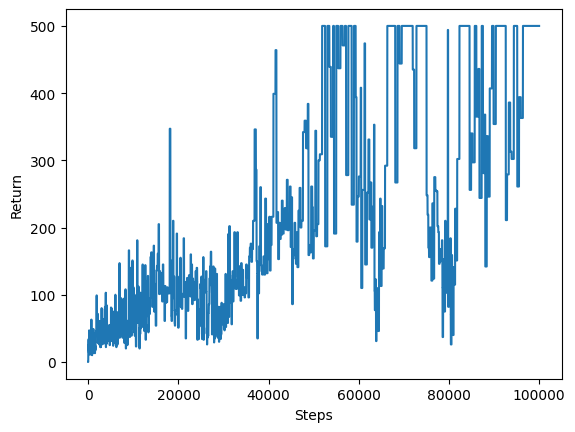

In [124]:
import matplotlib.pyplot as plt
# for i in range(20):
#   plt.plot(outs['metrics']['returns'][i])
plt.plot(out['metrics']['returns'][:100000])
plt.xlabel("Steps")
plt.ylabel("Return")
# plt.yscale('log')
plt.show()

In [84]:
len(out['metrics']['epsilon'])

2000

In [ ]:
# eps = 1.0
# e = []
# for i in range(2000):
#   if eps == 0.01:
#     print(i)
#   eps = jnp.maximum(0.99 * eps, 0.01)
#   e.append(eps)

Array(0.01, dtype=float32, weak_type=True)

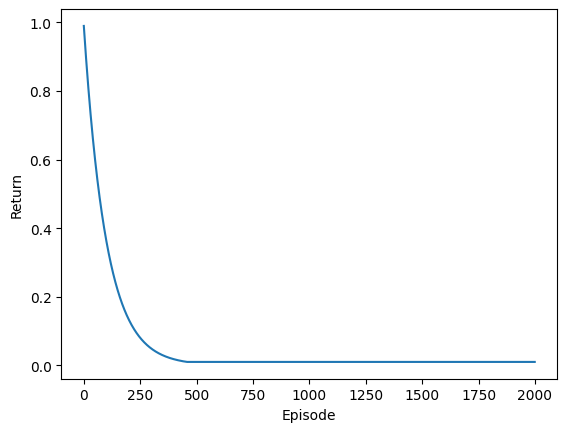

In [86]:
import matplotlib.pyplot as plt
# for i in range(20):
#   plt.plot(outs['metrics']['returns'][i])
plt.plot(e)
plt.xlabel("Episode")
plt.ylabel("Return")
# plt.yscale('log')
plt.show()